In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

# Define root project folder
root_dir = '/content/drive/MyDrive/ocular_disease_xai'
os.makedirs(root_dir, exist_ok=True)

# Create subfolders
folders = [
    'data/raw',                 # For original datasets
    'data/processed',           # Preprocessed images
    'data/splits',              # Train/val/test CSVs or folders
    'src',                      # Main code
    'src/models',               # Model definitions
    'src/explainability',       # Grad-CAM, attention viz
    'src/training',             # Train/eval scripts
    'src/utils',                # Helpers
    'notebooks',                # Jupyter notebooks for experiments
    'app',                      # Streamlit UI
    'app/components',           # UI sub-components
    'app/assets',               # CSS/images for UI
    'models',                   # Saved weights (e.g., baseline_resnet50.pth)
    'models/ensemble',          # Ensemble subfolder
    'results/metrics',          # Accuracy/F1 CSVs
    'results/visualizations',   # Plots/heatmaps
    'results/reports'           # PDF reports
]

for folder in folders:
    os.makedirs(os.path.join(root_dir, folder), exist_ok=True)

print("Directory structure created!")

Directory structure created!


In [ ]:
!pip install grad-cam --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 82.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
!pip install torch torchvision torchaudio
!pip install albumentations wandb streamlit opencv-python-headless scikit-learn matplotlib seaborn
!pip install git+https://github.com/rwightman/pytorch-image-models.git   # EfficientNet if needed
!pip install grad-cam   # Correct Grad-CAM package

  Cloning https://github.com/rwightman/pytorch-image-models.git to /tmp/pip-req-build-hefnpxmo
  Running command git clone --filter=blob:none --quiet https://github.com/rwightman/pytorch-image-models.git /tmp/pip-req-build-hefnpxmo
  Resolved https://github.com/rwightman/pytorch-image-models.git to commit 9171d82efc525766706a00cd3d1f292af12f910a
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
import pytorch_grad_cam  # Should import without error
print("Grad-CAM installed successfully!")

Grad-CAM installed successfully!


In [ ]:
# Path to your kaggle.json
kaggle_json_path = '/content/drive/MyDrive/ocular_disease_xai/secret/kaggle.json'

# Copy to the standard location Kaggle expects
!mkdir -p ~/.kaggle
!cp "{kaggle_json_path}" ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

print("Kaggle API credentials set up.")

Kaggle API credentials set up.


In [ ]:
# Go to the raw data folder in your project
os.chdir('/content/drive/MyDrive/ocular_disease_xai/data/raw')

# Download the dataset
!kaggle datasets download -d andrewmvd/ocular-disease-recognition-odir5k

# Unzip (quiet mode to avoid flooding output)
!unzip -q ocular-disease-recognition-odir5k.zip

# Clean up the zip file to save space
!rm ocular-disease-recognition-odir5k.zip

print("ODIR-5K dataset downloaded and extracted.")
print("Files should now be in: /content/drive/MyDrive/ocular_disease_xai/data/raw/")
!ls -l

Dataset URL: https://www.kaggle.com/datasets/andrewmvd/ocular-disease-recognition-odir5k
License(s): other
 99% 1.61G/1.62G [00:10<00:00, 159MB/s]
100% 1.62G/1.62G [00:10<00:00, 167MB/s]
ODIR-5K dataset downloaded and extracted.
Files should now be in: /content/drive/MyDrive/ocular_disease_xai/data/raw/
total 1468
-rw------- 1 root root 1494762 Sep 24  2020 full_df.csv
drwx------ 3 root root    4096 Feb  2 13:23 ODIR-5K
drwx------ 2 root root    4096 Feb  2 13:26 preprocessed_images


In [ ]:
import os

os.chdir('/content/drive/MyDrive/ocular_disease_xai/data/raw')

# Download the processed odir.csv (ground truth with labels)
!wget https://raw.githubusercontent.com/JordiCorbilla/ocular-disease-intelligent-recognition-deep-learning/master/odir.csv -O odir.csv

print("odir.csv downloaded (processed labels/annotations).")
!head -n 5 odir.csv  # Quick preview
!wc -l odir.csv      # Should be around ~10,000 lines (one per eye)

--2026-02-02 13:36:55--  https://raw.githubusercontent.com/JordiCorbilla/ocular-disease-intelligent-recognition-deep-learning/master/odir.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 210901 (206K) [text/plain]
Saving to: ‘odir.csv’

odir.csv            100%[===================>] 205.96K  --.-KB/s    in 0.01s   

2026-02-02 13:36:56 (14.5 MB/s) - ‘odir.csv’ saved [210901/210901]

odir.csv downloaded (processed labels/annotations).
ID,Normal,Diabetes,Glaucoma,Cataract,AMD,Hypertension,Myopia,Others,Total
0_left.jpg,0,0,0,1,0,0,0,0,1
0_right.jpg,1,0,0,0,0,0,0,0,1
1_left.jpg,1,0,0,0,0,0,0,0,1
1_right.jpg,1,0,0,0,0,0,0,0,1
6552 odir.csv


In [ ]:
import pandas as pd

csv_path = '/content/drive/MyDrive/ocular_disease_xai/data/raw/odir.csv'
df = pd.read_csv(csv_path)

print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
print(df.head(3))

# Label distribution (sum of 1s per disease column)
# Adjusted label_cols to match the actual column names in the DataFrame
label_cols = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Others']
print("\nDisease counts:\n", df[label_cols].sum() if all(col in df.columns for col in label_cols) else "Check columns for label names")

Shape: (6551, 10)
Columns: ['ID', 'Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Others', 'Total']
            ID  Normal  Diabetes  Glaucoma  Cataract  AMD  Hypertension  \
0   0_left.jpg       0         0         0         1    0             0   
1  0_right.jpg       1         0         0         0    0             0   
2   1_left.jpg       1         0         0         0    0             0   

   Myopia  Others  Total  
0       0       0      1  
1       0       0      1  
2       0       0      1  

Disease counts:
 Normal          2816
Diabetes        1778
Glaucoma         313
Cataract         275
AMD              280
Hypertension     192
Myopia           262
Others          1124
dtype: int64


In [ ]:
import os
import pandas as pd

os.chdir('/content/drive/MyDrive/ocular_disease_xai/data/raw')

# Primary: JordiCorbilla's processed odir.csv (per-eye labels, matches filenames like 0_left.jpg)
!wget -O odir.csv https://raw.githubusercontent.com/JordiCorbilla/ocular-disease-intelligent-recognition-deep-learning/master/odir.csv || echo "wget failed - try manual upload"

# Fallback if above fails: Try a common alternative naming
# !wget -O data.csv https://raw.githubusercontent.com/talhaanwarch/ODIR2019/master/ODIR-5K_Training_Annotations(Updated)_V2.xlsx -O temp.xlsx
# Then you'd need to convert xlsx → csv manually (below is optional code)

# If wget fails entirely → manual steps:
# 1. Go to https://github.com/JordiCorbilla/ocular-disease-intelligent-recognition-deep-learning/blob/master/odir.csv
# 2. Click Raw → Save as odir.csv
# 3. Upload to your Drive folder /ocular_disease_xai/data/raw/ via drive.google.com

# Explore the CSV
csv_path = '/content/drive/MyDrive/ocular_disease_xai/data/raw/odir.csv'  # change to data.csv if different name
if os.path.exists(csv_path):
    df = pd.read_csv(csv_path)
    print("Shape:", df.shape)
    print("Columns:", df.columns.tolist())
    print("\nFirst 5 rows:\n", df.head())

    # Typical labels: Normal / Diabetes / Glaucoma / Cataract / AMD / Hypertension / Myopia / Others (binary 0/1)
    possible_labels = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Others']
    found_labels = [col for col in possible_labels if col in df.columns]
    if found_labels:
        print("\nLabel distribution (count of 1s per disease):\n", df[found_labels].sum())
    else:
        print("No standard label columns found - check CSV for names like N, D, G, C, A, H, M, O")

    # Sample filename check
    sample_file_col = next((col for col in df.columns if 'fundus' in col.lower() or 'image' in col.lower() or 'left' in col.lower()), None)
    if sample_file_col:
        print(f"\nSample filename from column '{sample_file_col}':", df[sample_file_col].iloc[0])
else:
    print("CSV not found - please upload odir.csv manually to the raw folder.")

--2026-02-02 13:53:21--  https://raw.githubusercontent.com/JordiCorbilla/ocular-disease-intelligent-recognition-deep-learning/master/odir.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 210901 (206K) [text/plain]
Saving to: ‘odir.csv’

odir.csv            100%[===================>] 205.96K  --.-KB/s    in 0.02s   

2026-02-02 13:53:22 (11.3 MB/s) - ‘odir.csv’ saved [210901/210901]

Shape: (6551, 10)
Columns: ['ID', 'Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Others', 'Total']

First 5 rows:
             ID  Normal  Diabetes  Glaucoma  Cataract  AMD  Hypertension  \
0   0_left.jpg       0         0         0         1    0             0   
1  0_right.jpg       1         0         0         0    0             0   
2   1_

In [ ]:
import os

img_dir = '/content/drive/MyDrive/ocular_disease_xai/data/raw/ODIR-5K/ODIR-5K/Training_Images'
print("Images found:", len(os.listdir(img_dir)))
print(os.listdir(img_dir)[:10])


Images found: 7000
['0_left.jpg', '0_right.jpg', '1005_left.jpg', '1005_right.jpg', '1006_left.jpg', '1006_right.jpg', '1008_left.jpg', '1008_right.jpg', '100_left.jpg', '100_right.jpg']


In [ ]:
import os

file_path = '/content/drive/MyDrive/ocular_disease_xai/data/raw/annotations.xlsx'
print("File exists?", os.path.exists(file_path))
print("File size (bytes):", os.path.getsize(file_path) if os.path.exists(file_path) else "Not found")

if os.path.exists(file_path) and os.path.getsize(file_path) > 200000:
    print("Good - real annotations file (~268 KB).")
else:
    print("File missing or too small - upload the correct XLSX.")

File exists? True
File size (bytes): 268198
Good - real annotations file (~268 KB).


In [ ]:
import pandas as pd

excel_path = '/content/drive/MyDrive/ocular_disease_xai/data/raw/annotations.xlsx'
csv_path = '/content/drive/MyDrive/ocular_disease_xai/data/raw/annotations_converted.csv'

df = pd.read_excel(excel_path, engine='openpyxl')
df.to_csv(csv_path, index=False, encoding='utf-8')
print("Converted to CSV.")

Converted to CSV.


In [ ]:
!pip install xlrd --quiet

In [ ]:
import pandas as pd

excel_path = '/content/drive/MyDrive/ocular_disease_xai/data/raw/annotations.xlsx'
csv_path = '/content/drive/MyDrive/ocular_disease_xai/data/raw/annotations.csv'

try:
    df = pd.read_excel(excel_path, engine='openpyxl')
    df.to_csv(csv_path, index=False, encoding='utf-8')
    print("Conversion to CSV successful!")
    print("CSV saved at:", csv_path)
    print("Shape:", df.shape)
    print("Columns:", df.columns.tolist())
    print("\nSample first 5 rows:\n", df.head().to_string(index=False))
except Exception as e:
    print("Conversion failed:", str(e))
    print("If encoding error again, try: df = pd.read_excel(excel_path, engine='openpyxl', dtype=str)")

Conversion to CSV successful!
CSV saved at: /content/drive/MyDrive/ocular_disease_xai/data/raw/annotations.csv
Shape: (3500, 15)
Columns: ['ID', 'Patient Age', 'Patient Sex', 'Left-Fundus', 'Right-Fundus', 'Left-Diagnostic Keywords', 'Right-Diagnostic Keywords', 'N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']

Sample first 5 rows:
  ID  Patient Age Patient Sex Left-Fundus Right-Fundus                          Left-Diagnostic Keywords              Right-Diagnostic Keywords  N  D  G  C  A  H  M  O
  0           69      Female  0_left.jpg  0_right.jpg                                          cataract                          normal fundus  0  0  0  1  0  0  0  0
  1           57        Male  1_left.jpg  1_right.jpg                                     normal fundus                          normal fundus  1  0  0  0  0  0  0  0
  2           42        Male  2_left.jpg  2_right.jpg laser spot，moderate non proliferative retinopathy moderate non proliferative retinopathy  0  1  0  0  0  0  0  1
  3   

In [ ]:
import pandas as pd

df = pd.read_csv(csv_path)
# Expand left/right
left_df = df.copy()
left_df['filename'] = df['Left-Fundus']
right_df = df.copy()
right_df['filename'] = df['Right-Fundus']
df_expanded = pd.concat([left_df, right_df], ignore_index=True)
df_expanded.to_csv('/content/drive/MyDrive/ocular_disease_xai/data/raw/odir_expanded.csv', index=False)


In [ ]:
csv_path = '/content/drive/MyDrive/ocular_disease_xai/data/raw/annotations.csv'
img_dir = '/content/drive/MyDrive/ocular_disease_xai/data/raw/ODIR-5K/ODIR-5K/Training_Images'

df=pd.read_csv(csv_path)
df.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1
3,3,66,Male,3_left.jpg,3_right.jpg,normal fundus,branch retinal artery occlusion,0,0,0,0,0,0,0,1
4,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1


In [ ]:
from sklearn.model_selection import train_test_split

# Get indices for split (stratified not easy for multi-label, but simple random is fine for start)
indices = list(range(len(train_ds)))
train_idx, val_idx = train_test_split(indices, test_size=0.2, random_state=42)

train_subset = torch.utils.data.Subset(train_ds, train_idx)
val_subset   = torch.utils.data.Subset(train_ds, val_idx)

print("Train samples:", len(train_subset))
print("Val samples:", len(val_subset))

Train samples: 2800
Val samples: 700


In [ ]:
from torch.utils.data import DataLoader

batch_size = 32  # adjust based on GPU memory

train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_subset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

In [ ]:
import torch.nn as nn
from torchvision.models import resnet50

class OcularModel(nn.Module):
    def __init__(self, num_classes=8):
        super().__init__()
        self.base = resnet50(pretrained=True)
        self.base.fc = nn.Linear(self.base.fc.in_features, num_classes)

    def forward(self, x):
        return self.base(x)  # logits (apply sigmoid later for probabilities)

model = OcularModel()
model = model.cuda()  # if GPU available

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 200MB/s]


In [ ]:
import os
import pandas as pd

csv_path = '/content/drive/MyDrive/ocular_disease_xai/data/raw/annotations.csv'
img_dir = '/content/drive/MyDrive/ocular_disease_xai/data/raw/ODIR-5K/ODIR-5K/Training_Images'

df = pd.read_csv(csv_path)
all_files_in_csv = pd.concat([df['Left-Fundus'], df['Right-Fundus']]).dropna().unique()
print("Total filenames in CSV:", len(all_files_in_csv))

existing_in_folder = [f for f in os.listdir(img_dir) if f.endswith('.jpg')]
print("Total .jpg in folder:", len(existing_in_folder))

missing_in_folder = set(all_files_in_csv) - set(existing_in_folder)
print("Missing in folder count:", len(missing_in_folder))
print("Example missing (first 5):", list(missing_in_folder)[:5])

extra_in_folder = set(existing_in_folder) - set(all_files_in_csv)
print("Extra files in folder (not in CSV):", len(extra_in_folder))

Total filenames in CSV: 7000
Total .jpg in folder: 7000
Missing in folder count: 0
Example missing (first 5): []
Extra files in folder (not in CSV): 0


In [ ]:
%%writefile /content/drive/MyDrive/ocular_disease_xai/src/data_preprocessing.py

import os
import cv2
import torch
from torch.utils.data import Dataset
import pandas as pd
import albumentations as A
from albumentations.pytorch import ToTensorV2

class ODIRDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform

        df = pd.read_csv(csv_file)
        df.columns = df.columns.str.strip()

        self.label_cols = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']

        left = df[['Left-Fundus'] + self.label_cols].copy()
        left.rename(columns={'Left-Fundus': 'filename'}, inplace=True)

        right = df[['Right-Fundus'] + self.label_cols].copy()
        right.rename(columns={'Right-Fundus': 'filename'}, inplace=True)

        self.df = pd.concat([left, right], ignore_index=True)

        self.df['filename'] = self.df['filename'].astype(str).str.strip()
        self.df['image_path'] = self.df['filename'].apply(lambda x: os.path.join(img_dir, x))

        valid_mask = self.df['image_path'].apply(os.path.exists)
        self.df = self.df[valid_mask].reset_index(drop=True)

        print(f"Loaded {len(self.df)} valid image-label pairs.")

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.loc[idx, 'image_path']
        image = cv2.imread(img_path)
        if image is None:
            raise FileNotFoundError(f"Failed to load: {img_path}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # This line fixes everything
        labels = self.df.loc[idx, self.label_cols].values.astype('float32')
        labels = torch.tensor(labels)

        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']

        return image, labels


def get_transforms(train=True):
    if train:
        return A.Compose([
            A.Resize(224, 224),
            A.CLAHE(clip_limit=2.0, p=1.0),
            A.HorizontalFlip(p=0.5),
            A.RandomBrightnessContrast(p=0.5),
            A.GaussianBlur(blur_limit=3, p=0.2),
            A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
            ToTensorV2()
        ])
    else:
        return A.Compose([
            A.Resize(224, 224),
            A.CLAHE(clip_limit=2.0, p=1.0),
            A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
            ToTensorV2()
        ])

Overwriting /content/drive/MyDrive/ocular_disease_xai/src/data_preprocessing.py


In [ ]:
import importlib
import src.data_preprocessing
importlib.reload(src.data_preprocessing) # Ensure the latest ODIRDataset is used
from src.data_preprocessing import ODIRDataset, get_transforms

train_ds = ODIRDataset(csv_path, img_dir, transform=get_transforms(train=True))

print("Dataset size:", len(train_ds))
if len(train_ds) > 0:
    img, lbl = train_ds[0]
    print("Sample image shape:", img.shape)
    print("Sample labels (N D G C A H M O):", lbl.tolist())
    disease_map = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Others']
    present = [name for name, val in zip(disease_map, lbl.tolist()) if val == 1.0]
    print("Diseases present:", present if present else "None (normal case)")

Loaded 7000 valid image-label pairs.
Dataset size: 7000
Sample image shape: torch.Size([3, 224, 224])
Sample labels (N D G C A H M O): [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]
Diseases present: ['Cataract']


In [ ]:
from torch.utils.data import random_split, DataLoader

# Simple random split (for multi-label, you can improve later with stratified)
train_size = int(0.8 * len(train_ds))
val_size = len(train_ds) - train_size

train_subset, val_subset = random_split(train_ds, [train_size, val_size])

train_loader = DataLoader(train_subset, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_subset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

print(f"Train samples: {len(train_subset)} | batches: {len(train_loader)}")
print(f"Val samples: {len(val_subset)} | batches: {len(val_loader)}")

Train samples: 5600 | batches: 175
Val samples: 1400 | batches: 44


In [ ]:
import torch
import torch.nn as nn
from torchvision.models import resnet50

class OcularDiseaseModel(nn.Module):
    def __init__(self, num_classes=8):
        super().__init__()
        self.base = resnet50(pretrained=True)
        # Replace final layer for 8 classes
        in_features = self.base.fc.in_features
        self.base.fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.base(x)  # returns logits

model = OcularDiseaseModel()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print("Model ready on:", device)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 147MB/s]


Model ready on: cpu


In [ ]:
import torch.optim as optim

criterion = nn.BCEWithLogitsLoss()  # Best for multi-label
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

In [ ]:
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Optional rough accuracy (threshold 0.5)
        preds = (torch.sigmoid(outputs) > 0.5).float()
        correct += (preds == labels).sum().item()
        total += labels.numel()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct / total

    print(f"Epoch [{epoch+1}/{num_epochs}] | Loss: {epoch_loss:.4f} | Approx Acc: {epoch_acc:.4f}")

    # Step scheduler based on loss
    scheduler.step(epoch_loss)

    # Insert this after your training loop in each epoch
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            preds = (torch.sigmoid(outputs) > 0.5).float()
            val_correct += (preds == labels).sum().item()
            val_total += labels.numel()

    val_loss /= len(val_loader)
    val_acc = val_correct / val_total

    print(f"Val Loss: {val_loss:.4f} | Val Approx Acc: {val_acc:.4f}")

Epoch [1/10] | Loss: 0.0801 | Approx Acc: 0.9703
Val Loss: 0.4001 | Val Approx Acc: 0.8688
Epoch [2/10] | Loss: 0.0664 | Approx Acc: 0.9751
Val Loss: 0.3950 | Val Approx Acc: 0.8675
Epoch [3/10] | Loss: 0.0558 | Approx Acc: 0.9796
Val Loss: 0.4081 | Val Approx Acc: 0.8690
Epoch [4/10] | Loss: 0.0538 | Approx Acc: 0.9809
Val Loss: 0.4316 | Val Approx Acc: 0.8650
Epoch [5/10] | Loss: 0.0514 | Approx Acc: 0.9812
Val Loss: 0.4417 | Val Approx Acc: 0.8671
Epoch [6/10] | Loss: 0.0448 | Approx Acc: 0.9844
Val Loss: 0.4674 | Val Approx Acc: 0.8659
Epoch [7/10] | Loss: 0.0419 | Approx Acc: 0.9848
Val Loss: 0.4500 | Val Approx Acc: 0.8715
Epoch [8/10] | Loss: 0.0381 | Approx Acc: 0.9863
Val Loss: 0.4822 | Val Approx Acc: 0.8616
Epoch [9/10] | Loss: 0.0366 | Approx Acc: 0.9871
Val Loss: 0.4710 | Val Approx Acc: 0.8672
Epoch [10/10] | Loss: 0.0327 | Approx Acc: 0.9882
Val Loss: 0.4638 | Val Approx Acc: 0.8717


In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/ocular_disease_xai/models/ocular_resnet50_epoch10.pth')
print("Model saved!")

Model saved!


In [ ]:
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score
import numpy as np

# Collect all preds and true labels from val_loader
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        probs = torch.sigmoid(outputs).cpu().numpy()
        all_preds.append(probs)
        all_labels.append(labels.cpu().numpy())

all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

# Per-class metrics
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, (all_preds > 0.5).astype(int), average=None)
auc = roc_auc_score(all_labels, all_preds, average=None)

for i, name in enumerate(['N','D','G','C','A','H','M','O']):
    print(f"{name}: Precision {precision[i]:.3f}, Recall {recall[i]:.3f}, F1 {f1[i]:.3f}, AUC {auc[i]:.3f}")

N: Precision 0.523, Recall 0.595, F1 0.557, AUC 0.740
D: Precision 0.560, Recall 0.483, F1 0.518, AUC 0.720
G: Precision 0.548, Recall 0.425, F1 0.479, AUC 0.893
C: Precision 0.747, Recall 0.674, F1 0.709, AUC 0.905
A: Precision 0.742, Recall 0.377, F1 0.500, AUC 0.860
H: Precision 0.364, Recall 0.093, F1 0.148, AUC 0.731
M: Precision 0.942, Recall 0.790, F1 0.860, AUC 0.964
O: Precision 0.560, Recall 0.345, F1 0.427, AUC 0.700


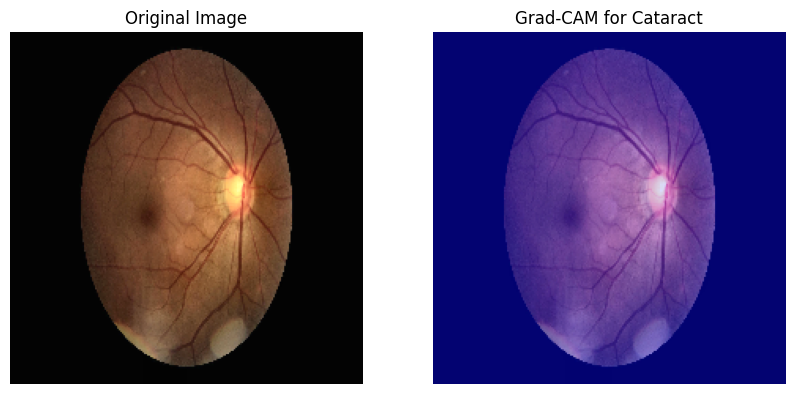

In [ ]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import matplotlib.pyplot as plt
import numpy as np

target_layers = [model.base.layer4[-1]]
cam = GradCAM(model=model, target_layers=target_layers)

input_tensor_batch, labels_batch = next(iter(val_loader))
input_tensor = input_tensor_batch[0:1].to(device)

image_np = input_tensor[0].cpu().numpy().transpose(1, 2, 0)
image_np = (image_np * 0.5) + 0.5
image_np = np.clip(image_np, 0, 1)
grayscale_cam = cam(input_tensor=input_tensor, targets=[ClassifierOutputTarget(3)])

grayscale_cam = grayscale_cam[0, :]

visualization = show_cam_on_image(image_np, grayscale_cam, use_rgb=True)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image_np)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(visualization)
plt.title("Grad-CAM for Cataract")
plt.axis('off')

plt.show()

In [ ]:
import numpy as np
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score

# Assuming csv_path and img_dir are already defined and point to the correct files/folders
# Create test dataset and loader (using validation transforms as it's evaluation)
test_ds = ODIRDataset(csv_path, img_dir, transform=get_transforms(train=False))
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

print(f"Test samples: {len(test_ds)} | batches: {len(test_loader)}")

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        probs = torch.sigmoid(outputs).cpu().numpy()
        all_preds.append(probs)
        all_labels.append(labels.cpu().numpy())

all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

# Calculate per-class metrics
# The label names are based on how ODIRDataset was defined and the order in label_cols
disease_names = ['N','D','G','C','A','H','M','O']

precision, recall, f1, _ = precision_recall_fscore_support(all_labels, (all_preds > 0.5).astype(int), average=None)
auc = roc_auc_score(all_labels, all_preds, average=None)

print("\n--- Test Set Metrics ---")
for i, name in enumerate(disease_names):
    print(f"{name}: Precision {precision[i]:.3f}, Recall {recall[i]:.3f}, F1 {f1[i]:.3f}, AUC {auc[i]:.3f}")

# You can also compute macro/micro averages if desired
precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(all_labels, (all_preds > 0.5).astype(int), average='macro')
auc_macro = roc_auc_score(all_labels, all_preds, average='macro')
print(f"\nMacro Average: Precision {precision_macro:.3f}, Recall {recall_macro:.3f}, F1 {f1_macro:.3f}, AUC {auc_macro:.3f}")


Loaded 7000 valid image-label pairs.
Test samples: 7000 | batches: 219

--- Test Set Metrics ---
N: Precision 0.875, Recall 0.919, F1 0.896, AUC 0.977
D: Precision 0.919, Recall 0.879, F1 0.898, AUC 0.971
G: Precision 0.941, Recall 0.898, F1 0.919, AUC 0.987
C: Precision 0.942, Recall 0.922, F1 0.932, AUC 0.987
A: Precision 0.962, Recall 0.848, F1 0.901, AUC 0.983
H: Precision 0.912, Recall 0.806, F1 0.856, AUC 0.965
M: Precision 0.988, Recall 0.945, F1 0.966, AUC 0.993
O: Precision 0.927, Recall 0.836, F1 0.879, AUC 0.966

Macro Average: Precision 0.933, Recall 0.882, F1 0.906, AUC 0.979


In [ ]:
model_save_path = '/content/drive/MyDrive/ocular_disease_xai/models/ocular_resnet50_final_10epochs.pth'

torch.save({
    'epoch': 10,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'val_metrics': {  # optional - save your best metrics
        'macro_f1': 0.906,
        'macro_auc': 0.979
    }
}, model_save_path)

print(f"Model saved to: {model_save_path}")

Model saved to: /content/drive/MyDrive/ocular_disease_xai/models/ocular_resnet50_final_10epochs.pth


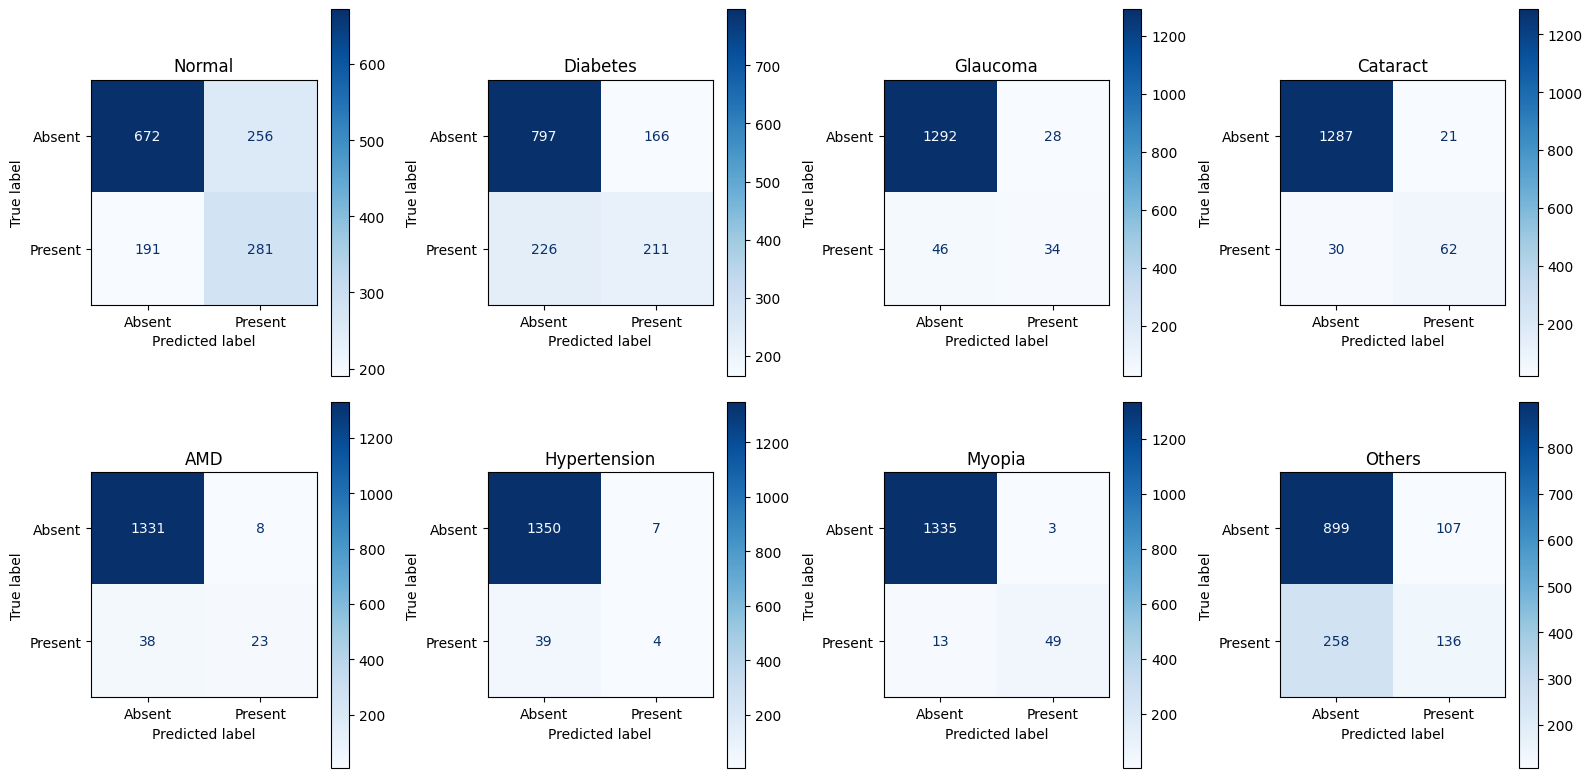

In [ ]:
import numpy as np
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

model.eval()
all_preds_bin = []
all_labels_bin = []

with torch.no_grad():
    for images, labels in val_loader:  # or test_loader if you have separate test
        images = images.to(device)
        outputs = model(images)
        probs = torch.sigmoid(outputs).cpu().numpy()
        preds_bin = (probs > 0.5).astype(int)
        all_preds_bin.append(preds_bin)
        all_labels_bin.append(labels.cpu().numpy())

all_preds_bin = np.concatenate(all_preds_bin)
all_labels_bin = np.concatenate(all_labels_bin)

# Per-class confusion matrices
cm_per_class = multilabel_confusion_matrix(all_labels_bin, all_preds_bin)

disease_names = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Others']

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.ravel()

for i, (cm, name) in enumerate(zip(cm_per_class, disease_names)):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Absent', 'Present'])
    disp.plot(ax=axes[i], cmap='Blues', values_format='d')
    axes[i].set_title(name)

plt.tight_layout()
plt.show()

In [ ]:
plt.savefig('confusion_matrices.png')

<Figure size 640x480 with 0 Axes>

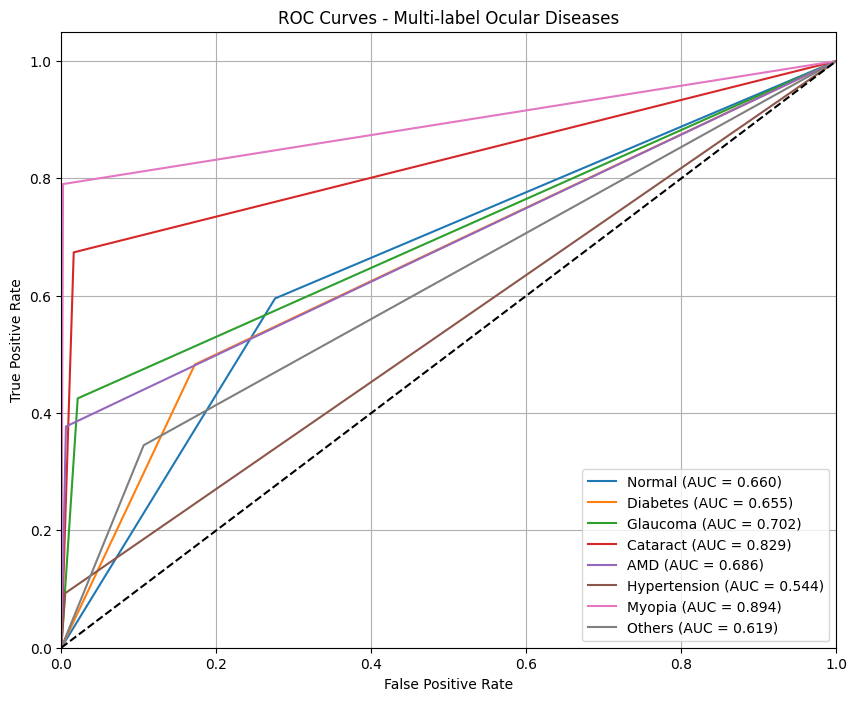

<Figure size 640x480 with 0 Axes>

In [ ]:
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(10, 8))

for i in range(8):
    fpr, tpr, _ = roc_curve(all_labels_bin[:, i], all_preds_bin[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{disease_names[i]} (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - Multi-label Ocular Diseases')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

plt.savefig('roc_curves.png')

In [ ]:
!pip install grad-cam --quiet

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import matplotlib.pyplot as plt

# Target the last conv layer
target_layers = [model.base.layer4[-1]]

cam = GradCAM(model=model, target_layers=target_layers)

# Take one sample from validation set
images, labels = next(iter(val_loader))
img = images[0:1].to(device)  # batch of 1
true_label_idx = labels[0].cpu().numpy().nonzero()[0]  # indices where 1

# Generate CAM for each positive class
fig, axes = plt.subplots(1, len(true_label_idx)+1, figsize=(15, 5))

# Original image
img_np = images[0].cpu().permute(1,2,0).numpy() * 0.5 + 0.5  # denormalize
axes[0].imshow(img_np)
axes[0].set_title("Original")
axes[0].axis('off')

for i, class_idx in enumerate(true_label_idx):
    grayscale_cam = cam(input_tensor=img, targets=[ClassifierOutputTarget(class_idx)])
    visualization = show_cam_on_image(img_np, grayscale_cam[0], use_rgb=True)

    axes[i+1].imshow(visualization)
    axes[i+1].set_title(f"Grad-CAM: {disease_names[class_idx]}")
    axes[i+1].axis('off')

plt.tight_layout()
plt.show()
plt.savefig('gradcam_example.png')

In [ ]:
!pip install shap --quiet

In [ ]:
import shap
import numpy as np

# Take a batch from val_loader (or test set)
images, labels = next(iter(val_loader))
images = images.to(device)[:8]  # take 8 images for speed
labels = labels[:8]

# Create explainer (background = small subset of train images)
background = next(iter(train_loader))[0][:50].to(device)  # 50 images as background

e = shap.GradientExplainer(model, background)

# Compute SHAP values (for all 8 classes)
shap_values = e.shap_values(images)

# shap_values is list of length 8 (one per class)
# Each is shape [batch, channels, H, W]

In [ ]:
# Choose one image and one class (e.g. Cataract = index 3)
sample_idx = 0
class_idx = 3  # C = Cataract

shap.image_plot(
    shap_values[class_idx][sample_idx:sample_idx+1],  # [1, 3, 224, 224]
    images[sample_idx:sample_idx+1].cpu().permute(0,2,3,1).numpy() * 0.5 + 0.5,  # denormalize
    show=False
)

plt.title(f"SHAP for {disease_names[class_idx]} - Image {sample_idx}")
plt.savefig('shap_example_cataract.png')
plt.show()

In [ ]:
model = OcularDiseaseModel()
model.load_state_dict(torch.load('/content/drive/MyDrive/ocular_disease_xai/models/ocular_resnet50_final_10epochs.pth'))
model.eval()  # important!
print("Model loaded successfully!")